# Creating nice maps with xarray

xarray built-in plotting functions can help make quick plots, but for your paper's figures you probably want to have more options. Let's look at what we can do:

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import xarray as xr

Load the sample dataset and geolon/geolat from static file (without holes on eliminated processors):

In [3]:
dataurl = 'http://35.188.34.63:8080/thredds/dodsC/OM4p5/'

ds = xr.open_dataset(f'{dataurl}/ocean_monthly_z.200301-200712.nc4',
                     chunks={'time':1, 'z_l': 1}, drop_variables=['average_DT', 'average_T1', 'average_T2'], engine='pydap')

In [4]:
grid = xr.open_dataset('./data/ocean_grid_sym_OM4_05.nc')

In [5]:
ds['geolon'] = grid['geolon']
ds['geolat'] = grid['geolat']

This is what a quick SST plot would look like:

In [6]:
sst_plot = ds['thetao'].isel(time=0, z_l=0)

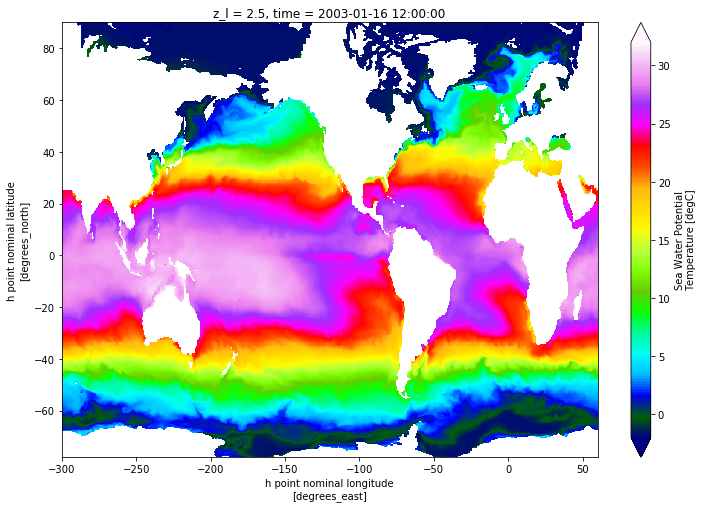

In [7]:
sst_plot.plot(figsize=[12,8], vmin=-2, vmax=32, cmap='gist_ncar')

We note that:
- lon/lat are wrong: xarray is plotting against xh/yh instead of geolon/geolat
- we don't really have control on labels, meridians/parallels, background,...

don't panic, we will fix this!

Let's define a sweet function with options that are more fitting for a publication quality figure:

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import numpy as np


def OM_global_plot(da, vmin=-999, vmax=999, vstep=1,
                   lon='geolon', lat='geolat',
                   cmap='jet', title='what is it?'):
    """ standard global plot for OM4 data array """
    
    fig = plt.figure(figsize=[16,10])
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # background
    url = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
    ax.add_wmts(url, 'BlueMarble_NextGeneration')
    
    # parallels/meridiens (adapt to taste)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}

    # contours
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    cf = da.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                          x=lon, y=lat,
                          levels=contours,
                          vmin=vmin, vmax=vmax,
                          add_labels=False, # remove labels
                          add_colorbar=False, # remove default colorbar
                          cmap=cmap)
    
    # add separate colorbar
    cb = plt.colorbar(cf, shrink=0.65)
    cb.ax.tick_params(labelsize=20)

    # title
    _ = plt.title(title, fontsize=18)
    return fig

**The fix for plotting against geolon/geolat is to explicitly add them as coordinates:**

In [9]:
sst_plot = sst_plot.assign_coords({'geolon': ds['geolon'],
                                   'geolat': ds['geolat']})

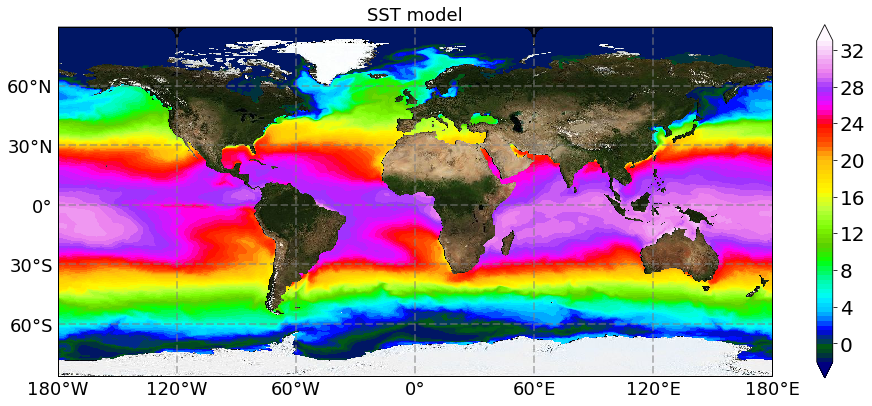

In [10]:
_ = OM_global_plot(sst_plot, vmin=-2, vmax=33, vstep=0.5,
                   lon='geolon', lat='geolat',
                   cmap='gist_ncar', title='SST model')

So much better!!

If you're having problem with generating plots using wmts, make sure you have the latest version of owslib (you may need to **pip uninstall owslib**,
clone [owslib source](https://github.com/geopython/OWSLib) and **python setup.py install**)
Now if you don't like the blue marble background (or other web mab service image), we can also fill the continents with a uniform color:

In [11]:
def OM_global_plot_mono(da, vmin=-999, vmax=999, vstep=1,
                        lon='geolon', lat='geolat', landcolor=1.,
                        cmap='jet', title='what is it?'):
    """ standard global plot for OM4 data array """
    
    fig = plt.figure(figsize=[16,10])
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}

    # contours
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    cf = da.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                          x=lon, y=lat,
                          levels=contours,
                          vmin=vmin, vmax=vmax,
                          add_labels=False,
                          add_colorbar=False,
                          cmap=cmap)
    # add separate colorbar
    cb = plt.colorbar(cf, shrink=0.65)
    cb.ax.tick_params(labelsize=20)

    # create a land 'topo' array with uniform value (0 < landcolor < 2)
    topo = xr.DataArray(data=landcolor * np.ones(sst_plot.shape), dims=sst_plot.dims)
    # make it exist only when ocean data is nan
    topo = topo.where(np.isnan(da))
    # assign true coords
    topo = topo.assign_coords({'geolon': sst_plot['geolon'],
                               'geolat': sst_plot['geolat']})
    # plot
    _ = topo.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                             x=lon, y=lat, cmap='binary',
                             vmin=0, vmax=2, add_labels=False,
                             add_colorbar=False)
    
    
    # title
    _ = plt.title(title, fontsize=18)
    return fig

Now we can pick any land color between white (0) and black (2):

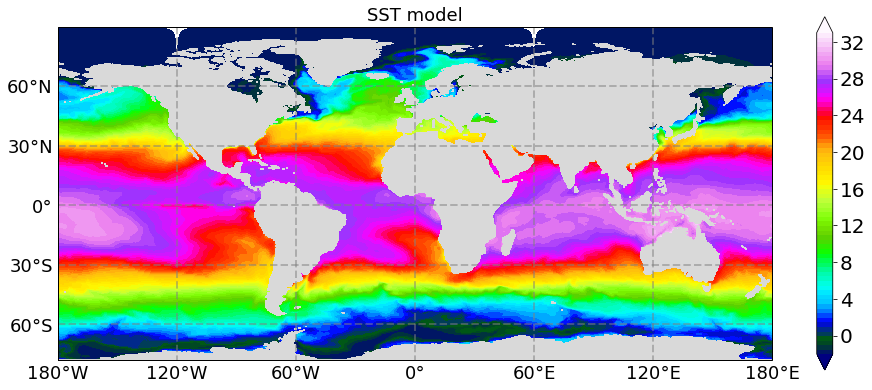

In [12]:
_ = OM_global_plot_mono(sst_plot, vmin=-2, vmax=33, vstep=0.5,
                        lon='geolon', lat='geolat', landcolor=0.3,
                        cmap='gist_ncar', title='SST model')

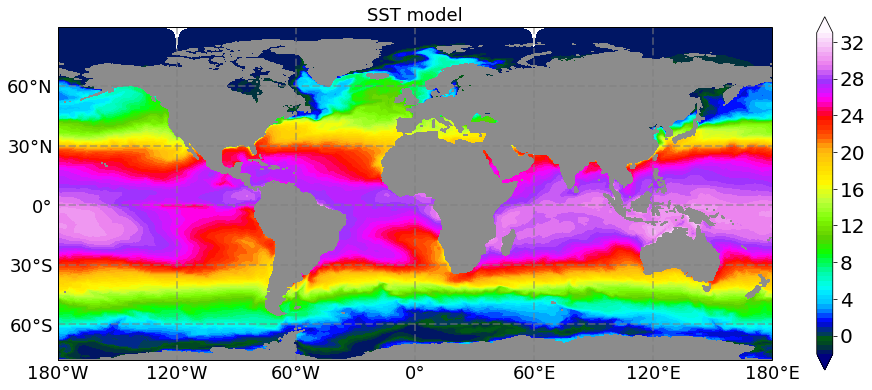

In [13]:
_ = OM_global_plot_mono(sst_plot, vmin=-2, vmax=33, vstep=0.5,
                        lon='geolon', lat='geolat', landcolor=0.9,
                        cmap='gist_ncar', title='SST model')

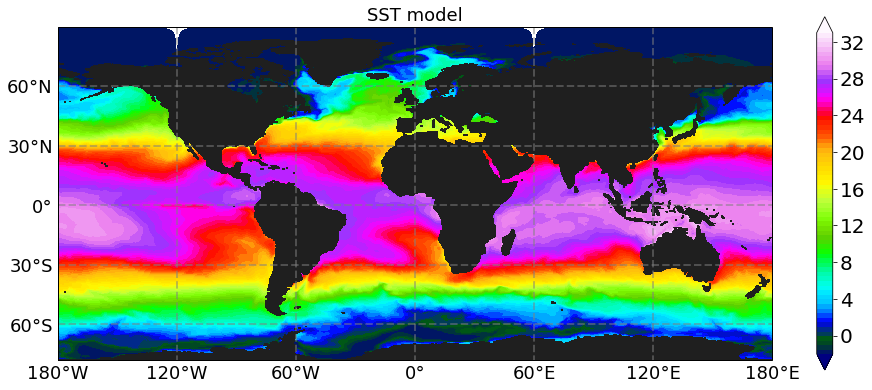

In [14]:
_ = OM_global_plot_mono(sst_plot, vmin=-2, vmax=33, vstep=0.5,
                        lon='geolon', lat='geolat', landcolor=1.75,
                        cmap='gist_ncar', title='SST model')

## Polar projections

Disclaimer: cartopy is not really doing a great job at polar projections and sone features are not supported (parallel/meridians for example). This may not make the cut for publications, but this may still be useful.

In [15]:
def OM_global_plot_npolar(da, vmin=-999, vmax=999, minlat=60,
                         lon='geolon', lat='geolat', landcolor=1.,
                         cmap='jet', title='what is it?'):
    """ standard global plot for OM4 data array """

    fig = plt.figure(figsize=[16,10])
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-30.0))

    ax.set_extent([-300, 60, minlat, 90], ccrs.PlateCarree())
    
    cf = da.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                            x=lon, y=lat,
                            vmin=vmin, vmax=vmax,
                            add_labels=False,
                            add_colorbar=False,
                            cmap=cmap)
    # add separate colorbar
    cb = plt.colorbar(cf, shrink=1.)
    cb.ax.tick_params(labelsize=20)

    # create a land 'topo' array with uniform value (0 < landcolor < 2)
    topo = xr.DataArray(data=landcolor * np.ones(da.shape), dims=da.dims)
    # make it exist only when ocean data is nan
    topo = topo.where(np.isnan(da))
    # assign true coords
    topo = topo.assign_coords({lon: da[lon],
                               lat: da[lat]})
    # plot
    _ = topo.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                             x=lon, y=lat, cmap='binary',
                             vmin=0, vmax=2, add_labels=False,
                             add_colorbar=False)


    # title
    _ = plt.title(title, fontsize=18)
    return fig

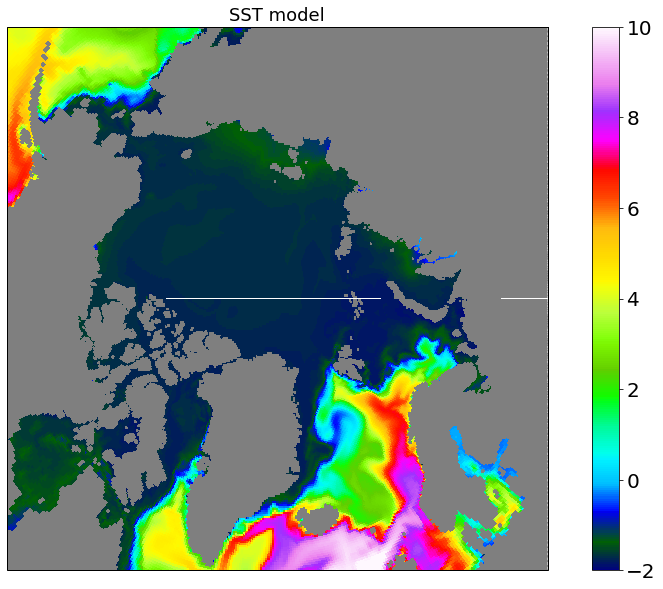

In [16]:
_ = OM_global_plot_npolar(sst_plot, vmin=-2, vmax=10, minlat=60,
                         lon='geolon', lat='geolat', landcolor=1.,
                         cmap='gist_ncar', title='SST model')

In [17]:
def OM_global_plot_spolar(da, vmin=-999, vmax=999, minlat=-60,
                         lon='geolon', lat='geolat', landcolor=1.,
                         cmap='jet', title='what is it?'):
    """ standard global plot for OM4 data array """

    fig = plt.figure(figsize=[16,10])
    ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-60.))

    ax.set_extent([-300, 60, minlat, -90], ccrs.PlateCarree())
    
    cf = da.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                            x=lon, y=lat,
                            vmin=vmin, vmax=vmax,
                            add_labels=False,
                            add_colorbar=False,
                            cmap=cmap)
    # add separate colorbar
    cb = plt.colorbar(cf, shrink=1.)
    cb.ax.tick_params(labelsize=20)

    # create a land 'topo' array with uniform value (0 < landcolor < 2)
    topo = xr.DataArray(data=landcolor * np.ones(da.shape), dims=da.dims)
    # make it exist only when ocean data is nan
    topo = topo.where(np.isnan(da))
    # assign true coords
    topo = topo.assign_coords({lon: da[lon],
                               lat: da[lat]})
    # plot
    _ = topo.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                             x=lon, y=lat, cmap='binary',
                             vmin=0, vmax=2, add_labels=False,
                             add_colorbar=False)


    # title
    _ = plt.title(title, fontsize=18)
    return fig

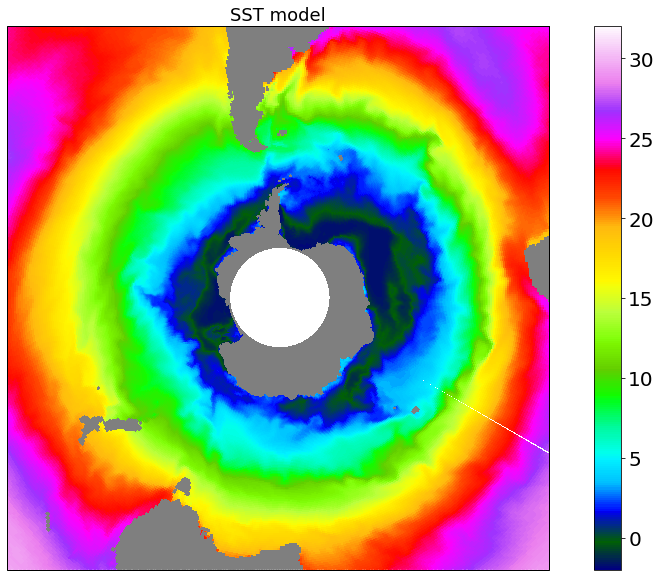

In [18]:
_ = OM_global_plot_spolar(sst_plot, vmin=-2, vmax=32, minlat=-30,
                         lon='geolon', lat='geolat', landcolor=1.,
                         cmap='gist_ncar', title='SST model')

Now go write that paper! :)